In [38]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations, product
import seaborn as sns
import copy

import tensorflow as tf
import tensorflow_lattice as tfl
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from keras.optimizers import Adam, Nadam, RMSprop
from keras.models import clone_model
import keras_tuner as kt
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model
from keras.losses import Poisson, Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

import xgboost as xgb
from scipy.stats import uniform, randint
from pygam import GammaGAM, GAM, s, f, l, te # s for spline, f for factor, l for linear, te for tensor product
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from interpret.glassbox import ExplainableBoostingRegressor
import joblib

In [39]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [40]:
############################ 1. DATA PREPARATION ############################

#-------------------------- import data --------------------------
data = pd.read_csv("synthetic_low_var.csv")

In [41]:
#-------------------------- remove outliers --------------------------
log_claim = np.log(data['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_cleaned = data[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.384709,0.070514,0.245303,-0.564460,-0.450318,0.531209,-0.139983,-0.999956,0.009359,317.866963
1,0.430379,-0.875990,0.808088,0.648436,0.174499,-0.765558,-0.898927,-0.168761,0.081209,-0.263657,78.581657
2,0.205527,0.977570,0.004793,-0.431433,0.975227,0.473320,0.995090,0.794291,-0.802390,-0.861454,516.366318
3,0.089766,0.438181,-0.798260,0.756793,0.901734,0.431272,-0.864656,0.512576,0.085770,-0.545924,17229.567290
4,-0.152690,0.515139,0.055164,0.282328,-0.314057,0.639535,-0.581069,0.940797,-0.261984,-0.425629,200.194269
...,...,...,...,...,...,...,...,...,...,...,...
49995,0.092658,0.451842,0.805609,-0.262674,0.758215,-0.205461,0.443849,-0.978784,0.740276,0.645713,55.754110
49996,0.386621,0.015041,-0.538708,-0.389854,-0.632906,-0.311577,0.027367,-0.845545,0.010439,0.868084,8.951832
49997,-0.532650,0.620266,0.162028,-0.570751,0.005453,0.235543,0.099723,0.663875,0.851769,0.066433,9.645558
49998,0.661848,0.102065,-0.526136,-0.408447,0.373860,-0.328123,0.756798,-0.514888,0.618938,0.761628,1447.660375


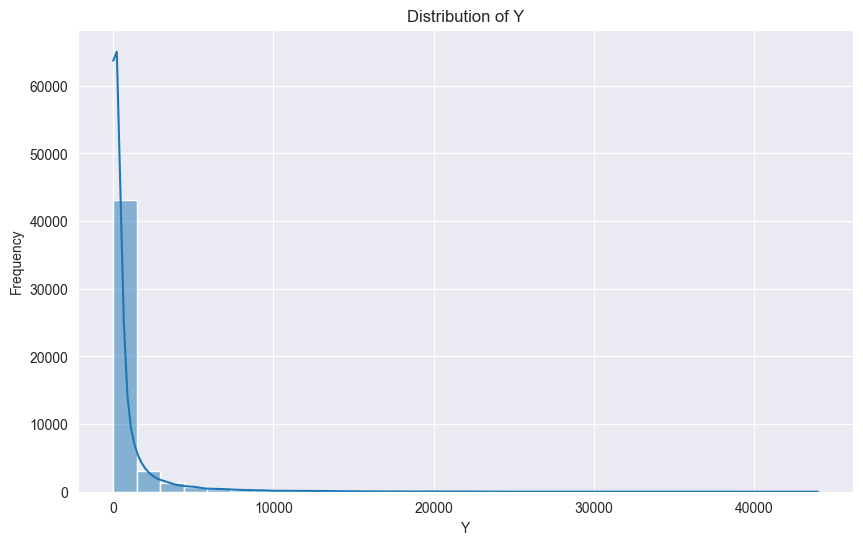

In [42]:
#-------------------------- distribution of response --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(dt_cleaned['Y'], bins = 30, kde = True) # draw the chart
plt.title('Distribution of Y')
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

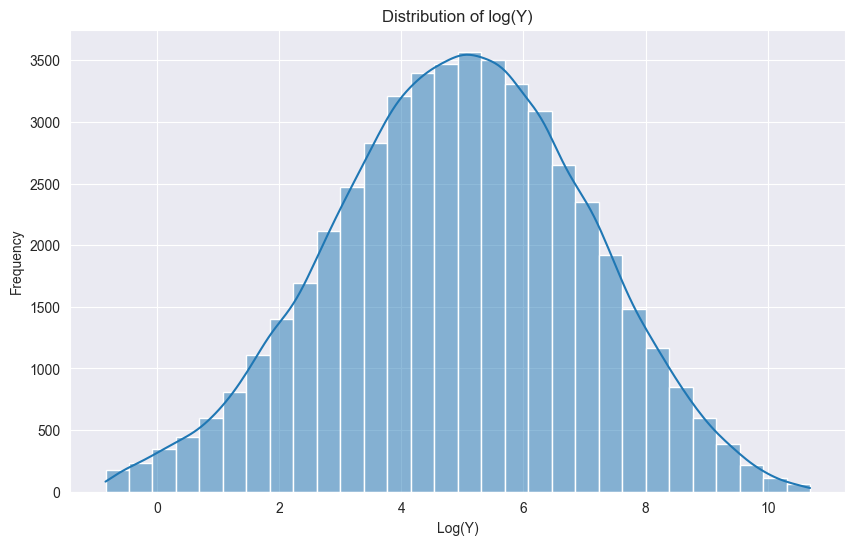

In [43]:
#-------------------------- distribution of log(response) --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y)')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [44]:
#-------------------------- column lists --------------------------
target_var = "Y" # target feature
imp_vars = [f"X{i}" for i in range(1,11)] # variables used for predictions
cat_vars = [] # categorical features

In [45]:
#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    dt_cleaned[imp_vars], dt_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [46]:
# -------------------------- create custom functions--------------------------
# gamma log likelihood
def gamma_nll(y_true, y_pred):
    y_pred = keras.ops.clip(y_pred, 1e-7, 1e30)
    loss = keras.ops.mean(y_true/y_pred - keras.ops.log(y_true/y_pred))
    return loss


# gamma log likelihood - numpy version
def gamma_nll_np(y_true, y_pred):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.clip(y_pred, 1e-7, 1e30)
    loss = np.mean(y_true/y_pred - np.log(y_true/y_pred))
    return loss

In [47]:
############################ NEURAL NETS ############################
#-------------------------- define the neural network architecture--------------------------
def build_NN(hp):

    # tuning hyperparameters
    num_layers = hp.Int('num_dense_layers', 4, 20, step = 5) # number of hidden layers
    num_neurons = hp.Int(f'num_neurons', 50, 400, step = 80) # number of neurons first hidden layer
    dropout_rate = hp.Float(f'dropout_rate', min_value = 0, max_value = 0.3, step = 0.1) # dropout rate
    lr = hp.Float('learning_rate', min_value = 1e-5, max_value = 1e-3, sampling = 'log') # learning rate
    activation = "leaky_relu"

    # architecture
    input_layer = Input((X_train.shape[1],))
    x = input_layer
    for i in range(num_layers):
        num_units = num_neurons - i*int(num_neurons/num_layers)
        x = Dense(units = num_units, activation = activation)(x)
        x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation = "exponential", name = "final_output")(x)

    # model
    model = Model(inputs = input_layer, outputs = output_layer)
    
    # build model
    model.compile(optimizer = RMSprop(learning_rate = lr),
            loss = gamma_nll,
            metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    
    return model

In [48]:
# -------------------------- tune and fit the model --------------------------
# tuner
tuner_NN = kt.BayesianOptimization(
    build_NN,
    objective = 'val_loss',
    max_trials = 20,
    directory = "hyperparameter_synthetic_NN_low",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 50, restore_best_weights = True, verbose = 0)

# search for the best model
tuner_NN.search(X_train, y_train,
        epochs = 5_000,
        batch_size = 5_000,
        validation_data = (X_val, y_val),
        callbacks = [es])

# get the best model
model_NN = tuner_NN.get_best_models()[0]
tuner_NN.results_summary(1)

Reloading Tuner from hyperparameter_synthetic_NN_low/untitled_project/tuner0.json
Results summary
Results in hyperparameter_synthetic_NN_low/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 17 summary
Hyperparameters:
num_dense_layers: 4
num_neurons: 370
dropout_rate: 0.1
learning_rate: 0.001
Score: 2.137430191040039


/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [49]:
#-------------------------- evaluate predictive performance --------------------------
nn_nll, nn_rmse, nn_mae = model_NN.evaluate(X_test, y_test)

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 2.1453 - mean_absolute_error: 902.1906 - root_mean_squared_error: 2240.2830


In [50]:
############################ GLM ############################
# -------------------------- data prep --------------------------
# add intercept terms
train = sm.add_constant(X_main)
test = sm.add_constant(X_test)

# -------------------------- fit a GLM with Gaussian distribution --------------------------
model = sm.GLM(y_main, train, family = sm.families.Gamma(sm.families.links.log()))
model_glm = model.fit()

# get model summary
print(model_glm.summary())

/Users/tupho/miniconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                39645
Model:                            GLM   Df Residuals:                    39634
Model Family:                   Gamma   Df Model:                           10
Link Function:                    log   Scale:                          7.0931
Method:                          IRLS   Log-Likelihood:            -2.9620e+05
Date:                Fri, 08 Nov 2024   Deviance:                   1.2975e+05
Time:                        18:23:51   Pearson chi2:                 2.81e+05
No. Iterations:                    25   Pseudo R-squ. (CS):            0.05350
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5608      0.013    490.299      0.0

In [51]:
# -------------------------- evaluate model performance --------------------------
glm_pred = model_glm.predict(test)
glm_nll = gamma_nll_np(y_test, glm_pred)
glm_rmse = np.sqrt(mse(y_test, glm_pred))
glm_mae = mae(y_test, glm_pred)
print(f"Gamma negative loglikehood: {glm_nll}")
print(f"RMSE: {glm_rmse}")
print(f"MAE: {glm_mae}")

Gamma negative loglikehood: 2.635580146123834
RMSE: 2450.764164335934
MAE: 1097.3612946938142


In [52]:
############################ GBM ############################

# load model if already exists
gbm_name = "gbm_synthetic_low.joblib"
if os.path.exists(gbm_name):
    model_gbm = joblib.load(gbm_name)
    print(f"Model loaded from '{gbm_name}'")
else:
    # initialize XGBoost
    xgb_reg = xgb.XGBRegressor(
        objective = 'reg:gamma',
        seed = 2024,
        subsample = 0.8,
        verbosity = 0  # Suppress warnings
    )

    # tuning hyperparamters
    param_dist = {
        'eta': uniform(0.01, 0.2), # learning rate (0.01 to 0.21)
        'max_depth': randint(3, 11), # maximum tree depth (3 to 10)
        'n_estimators': randint(100, 501)  # number of trees (100 to 500)
    }

    # set up random search
    random_search_gbm = RandomizedSearchCV(
        estimator = xgb_reg,
        param_distributions = param_dist,
        n_iter = 50,  # Number of parameter settings sampled
        scoring = "neg_mean_gamma_deviance",
        cv = 5,
        verbose = 1,
        random_state = 2024,
        n_jobs = -1 # using all processors for parallel processing
    )

    # perform the search
    random_search_gbm.fit(X_main, y_main)
    model_gbm = random_search_gbm.best_estimator_ # get the best model

    # -------------------------- Best Parameters and Score --------------------------
    print("Best Hyperparameters:", random_search_gbm.best_params_)
    print("Best Gamma Log Likehood:", random_search_gbm.best_score_)
    print(f"New model fitted and saved to '{gbm_name}'")
    joblib.dump(model_gbm, gbm_name)

Model loaded from 'gbm_synthetic_low.joblib'


In [53]:
# -------------------------- evaluation --------------------------
gbm_pred = model_gbm.predict(X_test) # get the prediction

# get metrics on test data
gbm_nll = gamma_nll_np(y_test, gbm_pred)
gbm_rmse = np.sqrt(mse(y_test, gbm_pred))
gbm_mae = mae(y_test, gbm_pred)
print(f"Gamma negative loglikehood: {gbm_nll}")
print(f"RMSE: {gbm_rmse}")
print(f"MAE: {gbm_mae}")

Gamma negative loglikehood: 1.7208187031099742
RMSE: 2033.155072070895
MAE: 664.8933501939648


In [54]:
############################ GAM ############################
# -------------------------- GAM with main effects only --------------------------
gam_name = "gam_synthetic_low.joblib"
if not os.path.exists(gam_name):
    # fit the model
    gam_main_model = GammaGAM(
        s(0) +          # spline for X1
        s(1) +          # spline for X2
        s(2, constraints = 'monotonic_dec') +  # negative monotonicity for X3
        s(3) +          # spline for X4
        s(4) +          # spline for X5
        s(5) +          # spline for X6
        s(6) +          # spline for X7
        s(7) +          # spline for X8
        s(8) +          # spline for X9
        s(9)            # spline for X10
    ).fit(X_train, y_train)
    gam_main_model.summary()

In [55]:
# -------------------------- get the validation loss --------------------------
if not os.path.exists(gam_name):
    gam_main_pred = gam_main_model.predict(X_val)
    gam_main_val_loss = gamma_nll_np(y_val, gam_main_pred)
    print(f"Validation loss of GAM main effect model: {gam_main_val_loss}")

In [56]:
#-------------------------- train-test split --------------------------
gam_imp_vars = [f"X{i}" for i in range(1,9)]
X_train_gam = X_train[gam_imp_vars]
X_val_gam = X_val[gam_imp_vars]
X_test_gam = X_test[gam_imp_vars]

In [57]:
# -------------------------- select pairwise interaction effects --------------------------
if not os.path.exists(gam_name):
    candidate_interactions = list(combinations(range(X_train_gam.shape[1]), 2)) # the last two variables have been identified as insignificant
    interaction_losses = {}

    # evaluate each pairwise interaction effect
    for interaction in candidate_interactions:

        # GAM with 1 pairwise interaction effect
        gam_pairwise_model = GammaGAM(
            s(0) +          # spline for X1
            s(1) +          # spline for X2
            s(2, constraints = 'monotonic_dec') +  # negative monotonicity for X3
            s(3) +          # spline for X4
            s(4) +          # spline for X5
            s(5) +         # spline for X6
            s(6) +          # spline for X7
            s(7) +          # spline for X8
            te(interaction[0], interaction[1]), # tensor product for interaction effect
            n_splines = 10
        ).fit(X_train_gam, y_train)
        
        # Calculate validation loss
        gam_pairwise_pred = gam_pairwise_model.predict(X_val_gam)
        gam_pairwise_val_loss = gamma_nll_np(y_val, gam_pairwise_pred)
        interaction_losses[f"{interaction[0]}_{interaction[1]}"] = gam_pairwise_val_loss

In [58]:
# -------------------------- plot the validation loss --------------------------
if not os.path.exists(gam_name):
    # Convert interaction loss dictionary to a pandas DataFrame
    interaction_df = pd.DataFrame(list(interaction_losses.items()), columns = ['Interaction_Pair', 'Validation_Loss'])

    # Sort the DataFrame by Validation_Loss in increasing order
    interaction_df = interaction_df.sort_values(by = 'Validation_Loss', ascending = True)

    # Create the bar plot using Seaborn
    plt.figure(figsize = (16, 8))
    sns.lineplot(x = 'Interaction_Pair', y = 'Validation_Loss', data = interaction_df, marker = 'o')
    plt.axhline(gam_main_val_loss, color = 'red', linestyle = '--', label = 'Validation Loss of Main Effect Model')
    plt.xlabel('Interaction Effect Pairs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss for Interaction Effect Pairs (Sorted by Increasing Loss)')
    plt.legend()
    plt.show()

In [59]:
# -------------------------- define and fit the GAM model --------------------------
if os.path.exists(gam_name):
    model_gam = joblib.load(gam_name)
    print(f"Model loaded from '{gam_name}'")
else:
    model_gam = GammaGAM(
        s(0) +          # spline for X1
        s(1) +          # spline for X2
        s(2, constraints = 'monotonic_dec') +  # negative monotonicity for X3
        s(3) +          # spline for X4
        s(4) +          # spline for X5
        s(5) +          # spline for X6
        s(6) +          # spline for X7
        s(7) +          # spline for X8
        te(2, 3, constraints = ['monotonic_dec', None]) +  # interaction term between X3 and X4
        te(4, 5) +  # interaction term between X5 and X6
        te(6, 7)  # interaction term between X7 and X8
    )

    # -------------------------- define hyperparameter for tuning --------------------------
    # Define the hyperparameter grid
    lam_values = [0.001, 0.01, 0.1, 1]
    n_splines_values = [5, 10, 20, 30]


    # -------------------------- # Perform gridsearch --------------------------
    model_gam.gridsearch(np.asarray(X_train_gam), np.asarray(y_train), lam = lam_values, n_splines = n_splines_values)
    # model_gam.fit(np.asarray(X_train_gam), np.asarray(y_train))
    joblib.dump(model_gam, gam_name)
    print(f"New model fitted and saved to '{model_gam}'")
    
    # view the optimal hyperparameters
    print(f"Smoothness penalty: {model_gam.lam}")
    print(f"Number of splines: {model_gam.n_splines}")

Model loaded from 'gam_synthetic_low.joblib'


In [60]:
# -------------------------- evaluation --------------------------
gam_pred = model_gam.predict(X_test_gam) # get the prediction

# get metrics on test data
gam_nll = gamma_nll_np(y_test, gam_pred)
gam_rmse = np.sqrt(mse(y_test, gam_pred))
gam_mae = mae(y_test, gam_pred)
print(f"Gamma negative loglikehood: {gam_nll}")
print(f"RMSE: {gam_rmse}")
print(f"MAE: {gam_mae}")

Gamma negative loglikehood: 1.6864621979883996
RMSE: 2029.9629094837799
MAE: 721.0476168722389


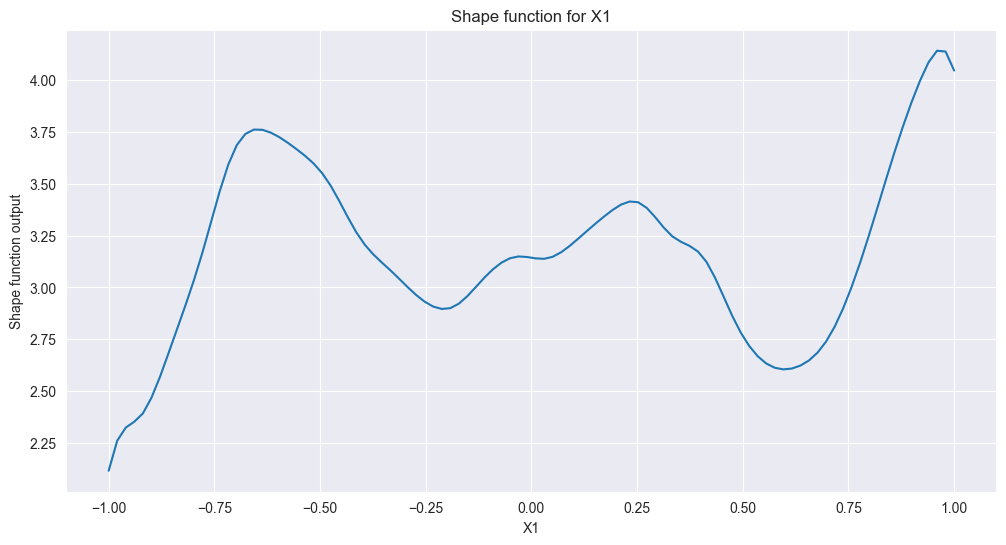

In [75]:
#-------------------------- view the shape function --------------------------
# generate input
var_name = "X1"
var_index = imp_vars.index(var_name)
grid_length = 100
grid = np.linspace(X_train_gam[var_name].min(), 
                   X_train_gam[var_name].max(), 
                   grid_length)
grid_inputs = []
for var in gam_imp_vars:
    if var == var_name:
        grid_inputs.append(grid)
    else:
        grid_inputs.append(np.zeros_like(grid))
grid_inputs = np.column_stack(grid_inputs)

# get the prediction
output = np.log(model_gam.predict(grid_inputs))
# output = np.log(model_gam.term_dependence(var_index, grid_inputs))

# create the plot
plt.figure(figsize = (12, 6))
sns.lineplot(x = grid, y = output)
plt.xlabel(f"{var_name}")
plt.ylabel('Shape function output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

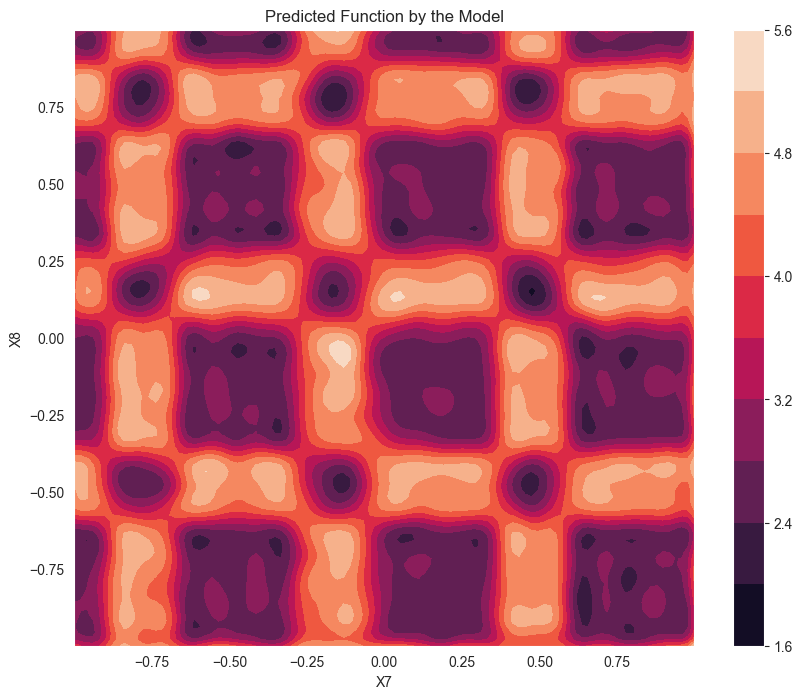

In [62]:
# -------------------------- View the heatmap --------------------------
pairwise_effect = ("X7", "X8")  # the pairwise effect we want to view

# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 100
var1_values = np.linspace(X_train_gam[pairwise_effect[0]].min(), 
                          X_train_gam[pairwise_effect[0]].max(), 
                          grid_length)
var2_values = np.linspace(X_train_gam[pairwise_effect[1]].min(), 
                          X_train_gam[pairwise_effect[1]].max(), 
                          grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
for var in gam_imp_vars:
    if var == pairwise_effect[0]:
        grid_inputs.append(grid_flat_var1)
    elif var == pairwise_effect[1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))
grid_inputs = np.column_stack(grid_inputs)

# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = np.log(model_gam.predict(grid_inputs))

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"{pairwise_effect[0]}")
plt.ylabel(f"{pairwise_effect[1]}")
plt.show()

In [63]:
############################ EXPLAINABLE BOOSTING MACHINE ############################
# load the model if already exists
ebm_name = "ebm_synthetic_low.joblib"
if os.path.exists(ebm_name):
    model_ebm = joblib.load(ebm_name)
    print(f"Model loaded from '{ebm_name}'")

else:
    # define the model
    ebm_reg = ExplainableBoostingRegressor(
        objective = "gamma_deviance",
        monotone_constraints = [0, 0, -1, 0, 0, 0, 0, 0, 0, 0],
        n_jobs = -1,
        random_state = 2024,
        validation_size = 0.25
    )

    # Define the hyperparameter grid
    param_grid = {
        'max_bins': [20, 50, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_leaves': [3, 10, 20, 50]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator = ebm_reg,
        param_grid = param_grid,
        scoring = 'neg_mean_gamma_deviance',
        n_jobs = -1,
        verbose = 2
    )

    # Fit GridSearchCV
    grid_search.fit(X_main, y_main)

    # Best parameters
    print("Best Hyperparameters:", grid_search.best_params_)

    # Model
    model_ebm = grid_search.best_estimator_

    joblib.dump(model_ebm, ebm_name)
    print(f"New model fitted and saved to '{ebm_name}'")

Model loaded from 'ebm_synthetic_low.joblib'


In [64]:
# -------------------------- evaluation --------------------------
ebm_pred = model_ebm.predict(X_test) # get the prediction

# get metrics on test data
ebm_nll = gamma_nll_np(y_test, ebm_pred)
ebm_rmse = np.sqrt(mse(y_test, ebm_pred))
ebm_mae = mae(y_test, ebm_pred)
print(f"Gamma negative loglikehood: {ebm_nll}")
print(f"RMSE: {ebm_rmse}")
print(f"MAE: {ebm_mae}")

Gamma negative loglikehood: 1.799176426843833
RMSE: 2189.6355497826676
MAE: 780.223678191536


In [65]:
model_ebm.term_features_

[(0,),
 (1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (7,),
 (8,),
 (9,),
 (0, 4),
 (1, 7),
 (3, 5),
 (3, 8),
 (4, 5),
 (4, 6),
 (4, 9),
 (6, 7),
 (6, 9)]

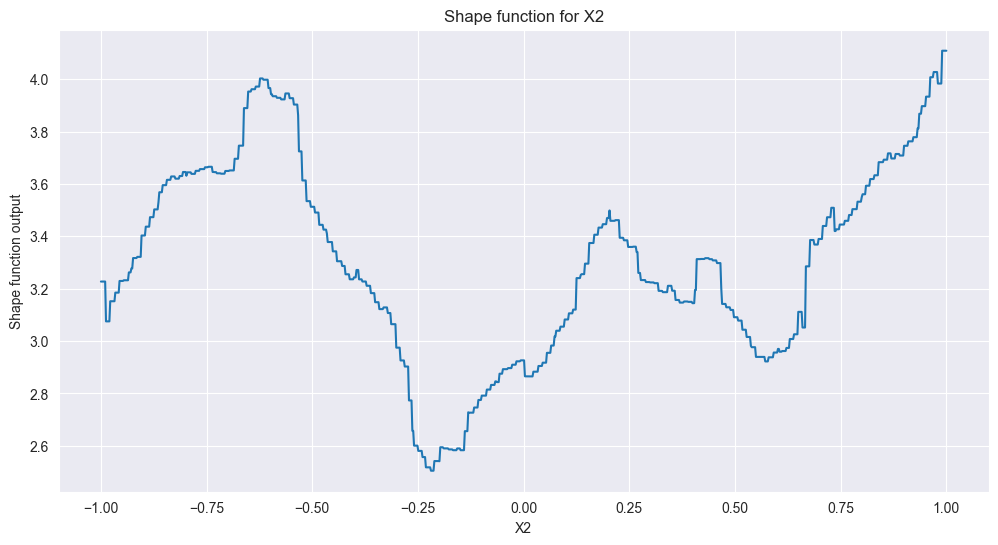

In [78]:
#-------------------------- view the shape function --------------------------
# generate input
var_name = "X2"
grid_length = 1000
grid = np.linspace(X_train[var_name].min(), 
                   X_train[var_name].max(), 
                   grid_length)
grid_inputs = []
for var in imp_vars:
    if var == var_name:
        grid_inputs.append(grid)
    else:
        grid_inputs.append(np.zeros_like(grid))
grid_inputs = np.column_stack(grid_inputs)

# get the prediction
output = np.log(model_ebm.predict(grid_inputs))

# create the plot
plt.figure(figsize = (12, 6))
sns.lineplot(x = grid, y = output)
plt.xlabel(f"{var_name}")
plt.ylabel('Shape function output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

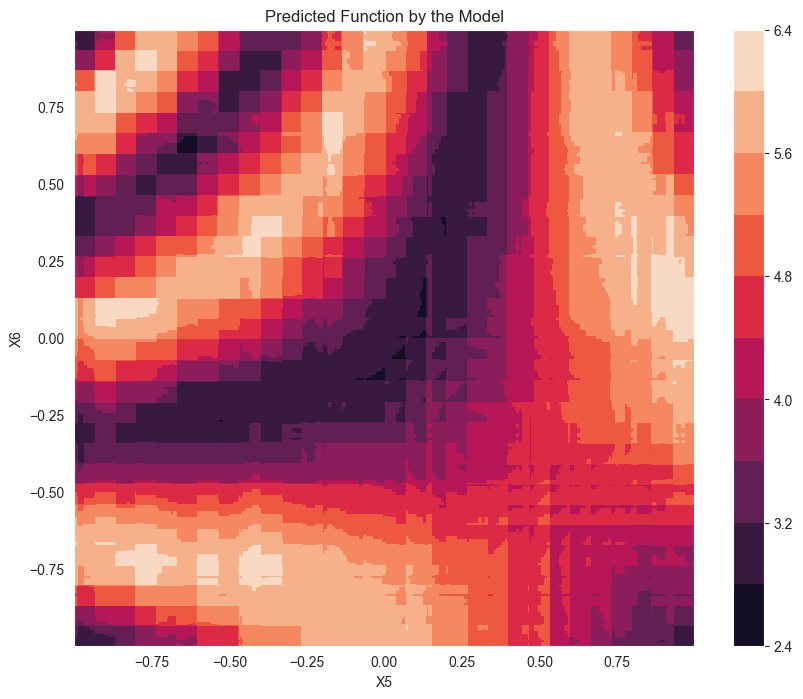

In [77]:
# -------------------------- View the heatmap --------------------------
pairwise_effect = ("X5", "X6")  # the pairwise effect we want to view

# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 1000
var1_values = np.linspace(X_train[pairwise_effect[0]].min(), 
                          X_train[pairwise_effect[0]].max(), 
                          grid_length)
var2_values = np.linspace(X_train[pairwise_effect[1]].min(), 
                          X_train[pairwise_effect[1]].max(), 
                          grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
for var in imp_vars:
    if var == pairwise_effect[0]:
        grid_inputs.append(grid_flat_var1)
    elif var == pairwise_effect[1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))
grid_inputs = np.column_stack(grid_inputs)

# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = np.log(model_ebm.predict(grid_inputs))

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"{pairwise_effect[0]}")
plt.ylabel(f"{pairwise_effect[1]}")
plt.show()

In [68]:
############################ LocalGLMnet ############################
#-------------------------- define model architecture --------------------------
def build_LGLMNet(hp):

    # tuning hyperparameters
    num_layers = hp.Int('num_dense_layers', 4, 10, step = 1) # number of hidden layers
    num_neurons = hp.Int(f'num_neurons', 50, 200, step = 40) # number of neurons per hidden layer
    dropout_rate = hp.Float(f'dropout_rate', min_value = 0, max_value = 0.3, step = 0.1) # dropout rate
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'softplus', 'swish'])

    # neural network
    attention_outputs = []
    input_layer = Input(shape = (X_train.shape[1],), name = "input_layer")
    for var in imp_vars:
        # get the corresponding input
        var_index = imp_vars.index(var)
        var_input = input_layer[:,var_index:var_index+1]

        # create the attention
        x = input_layer
        for i in range(num_layers):
            x = Dense(units = num_neurons, activation = activation)(x)
            x = Dropout(dropout_rate)(x)
        attention_layer = Dense(1, activation = "linear")(x)
        attention_output = Multiply()([var_input, attention_layer])
        attention_outputs.append(attention_output)

    # add the output of each network
    concat_layer = Concatenate()(attention_outputs)
    final_output = Dense(1, activation = "exponential")(concat_layer)

    # model
    model = Model(inputs = input_layer, outputs = final_output)
    
    # build model
    model.compile(optimizer = RMSprop(learning_rate = lr),
            loss = gamma_nll,
            metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    
    return model

In [69]:
# -------------------------- tune and fit the model --------------------------
# tuner
tuner_lglm = kt.BayesianOptimization(
    build_LGLMNet,
    objective = 'val_loss',
    max_trials = 20,
    directory = "hyperparameter_synthetic_lglm_low",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 50, restore_best_weights = True, verbose = 0)

# search for the best model
tuner_lglm.search(X_train, y_train,
        epochs = 5_000,
        batch_size = 5_000,
        validation_data = (X_val, y_val),
        callbacks = [es])

# get the best model
model_lglm = tuner_lglm.get_best_models()[0]
tuner_lglm.results_summary(1)

Reloading Tuner from hyperparameter_synthetic_lglm_low/untitled_project/tuner0.json
Results summary
Results in hyperparameter_synthetic_lglm_low/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 18 summary
Hyperparameters:
num_dense_layers: 8
num_neurons: 170
dropout_rate: 0.1
learning_rate: 0.0002444597320983687
activation: swish
Score: 2.07397723197937


/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 184 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [70]:
#-------------------------- evaluate predictive performance --------------------------
lglm_nll, lglm_rmse, lglm_mae = model_lglm.evaluate(X_test, y_test)

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0688 - mean_absolute_error: 946.1034 - root_mean_squared_error: 2279.3984


In [71]:
nam_nll = 1.654
nam_rmse = 2020.657
nam_mae = 698.9

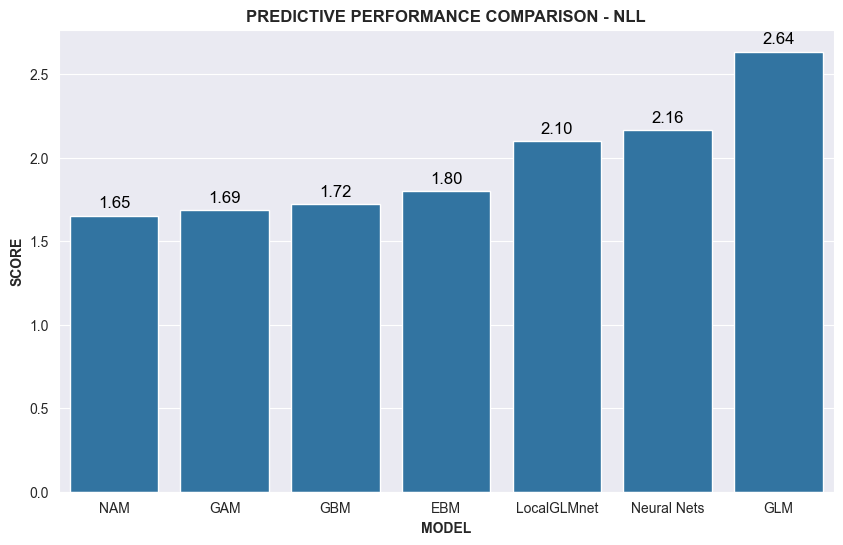

In [72]:
# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM',
              'GAM',
              'NAM',
              'EBM',
              'LocalGLMnet',
              'GBM',
              'Neural Nets'],
    'Gamma NLL': [glm_nll,
                gam_nll,
                nam_nll,
                ebm_nll,
                lglm_nll,
                gbm_nll,
                nn_nll]
}
df_performance = pd.DataFrame(df_performance)
df_performance_sorted = df_performance.sort_values(by='Gamma NLL') # sort in ascending order

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Model', y = 'Gamma NLL', data = df_performance_sorted)


# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.2f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 12, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON - NLL', fontsize = 12, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 10, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 10, fontweight = 'bold')

# size of x-label
barplot.tick_params(labelsize = 10)

# Show the plot
plt.show()

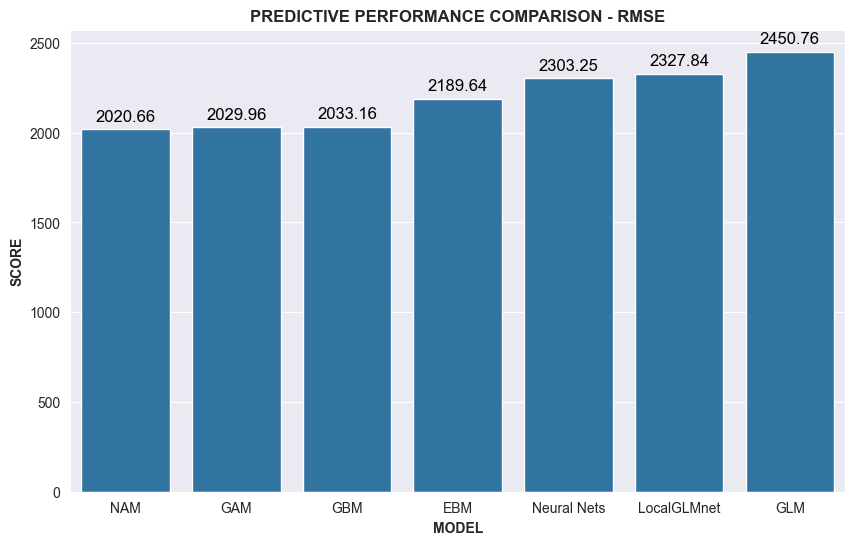

In [73]:
# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM',
              'GAM',
              'NAM',
              'EBM',
              'LocalGLMnet',
              'GBM',
              'Neural Nets'],
    'Gamma RMSE': [glm_rmse,
                gam_rmse,
                nam_rmse,
                ebm_rmse,
                lglm_rmse,
                gbm_rmse,
                nn_rmse]
}
df_performance = pd.DataFrame(df_performance)
df_performance_sorted = df_performance.sort_values(by='Gamma RMSE')

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Model', y = 'Gamma RMSE', data = df_performance_sorted)

# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.2f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 12, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON - RMSE', fontsize = 12, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 10, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 10, fontweight = 'bold')

# size of x-label
barplot.tick_params(labelsize = 10)

# Show the plot
plt.show()

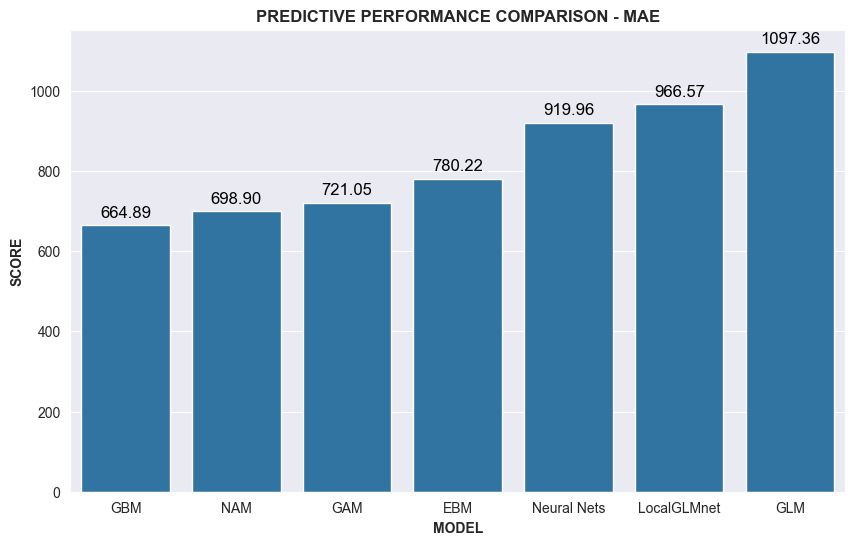

In [74]:
# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM',
              'GAM',
              'NAM',
              'EBM',
              'LocalGLMnet',
              'GBM',
              'Neural Nets'],
    'Gamma MAE': [glm_mae,
                gam_mae,
                nam_mae,
                ebm_mae,
                lglm_mae,
                gbm_mae,
                nn_mae]
}
df_performance = pd.DataFrame(df_performance)
df_performance_sorted = df_performance.sort_values(by='Gamma MAE')

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Model', y = 'Gamma MAE', data = df_performance_sorted)


# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.2f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 12, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON - MAE', fontsize = 12, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 10, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 10, fontweight = 'bold')

# size of x-label
barplot.tick_params(labelsize = 10)

# Show the plot
plt.show()